Hello Jose!

I’m happy to review your project today.
I will mark your mistakes and give you some hints how it is possible to fix them. We are getting ready for real job, where your team leader/senior colleague will do exactly the same. Don't worry and study with pleasure! 

Below you will find my comments - **please do not move, modify or delete them**.

You can find my comments in green, yellow or red boxes like this:

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Success. Everything is done succesfully.
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Remarks. Some recommendations.
</div>

<div class="alert alert-block alert-danger">

<b>Reviewer's comment</b> <a class="tocSkip"></a>

Needs fixing. The block requires some corrections. Work can't be accepted with the red comments.
</div>

You can answer me by using this:

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Text here.
</div>

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# **Taxi Demand Forecasting: Predicting Hourly Airport Orders**

## Project Overview

Sweet Lift Taxi company needs to optimize their driver allocation during peak hours at the airport. This project develops a machine learning model to predict the number of taxi orders for the next hour, helping the company manage resources more efficiently and reduce customer wait times.

The core objective is to build a predictive model with RMSE (Root Mean Square Error) below 48 on the test set, ensuring sufficient accuracy for operational planning.

## Methodology

Our approach follows a structured data science workflow:

1. **Data Preparation**:
   - Loading and examining historical taxi order data
   - Resampling data to hourly frequency for analysis and modeling
   - Creating a robust train-validation-test split (70/20/10) to ensure proper evaluation

2. **Exploratory Data Analysis**:
   - Analyzing temporal patterns at multiple frequencies (hourly, daily, weekly, monthly)
   - Decomposing the time series to identify trend, seasonality, and residual components
   - Examining autocorrelation and partial autocorrelation functions to understand time dependencies
   - Investigating cyclical patterns by hour of day, day of week, and month

3. **Feature Engineering**:
   - Creating time-based features (hour, day, week)
   - Implementing cyclical encoding for time variables using sine/cosine transformations
   - Generating lag features based on identified autocorrelation patterns
   - Adding rolling statistics to capture recent trends and volatility

4. **Model Development Strategy**:
   - Establishing baseline models (persistence and linear regression)
   - Training traditional time series models (ARIMA and SARIMA)
   - Implementing tree-based machine learning models (Decision Tree, Random Forest, LightGBM, XGBoost)
   - Fine-tuning the best performing models through hyperparameter optimization

5. **Evaluation Approach**:
   - Using multiple metrics (RMSE, MAE, MAPE, R²) for comprehensive evaluation
   - Validating models on a separate time period to ensure generalization
   - Testing the final model on an untouched test set for unbiased assessment
   - Analyzing prediction errors and feature importance for model interpretability

This systematic approach ensures we develop a robust forecasting solution while gaining valuable insights into the factors driving taxi demand patterns at the airport.

# **1. Exploratory Data Analysis**

In [ ]:
!pip install --upgrade pip
!pip install pmdarima

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.exceptions import ConvergenceWarning

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
data = pd.read_csv('datasets/taxi.csv')

# Check basic information
print("Data shape:", data.shape)
print("\nData types:")
print(data.dtypes)
print("\nFirst few rows:")
print(data.head())

Data shape: (26496, 2)

Data types:
datetime      object
num_orders     int64
dtype: object

First few rows:
              datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32


let's convert the datetime column to the datetime format and set it as the index, then resample the data by one hour as mentioned in the instructions:

In [3]:
# Convert datetime column to datetime type
data['datetime'] = pd.to_datetime(data['datetime'])

# Set datetime as index
data.set_index('datetime', inplace=True)

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(data.describe())

# Resample data by hour (sum of orders per hour)
hourly_data = data.resample('1H').sum()

# Print first few rows of original and resampled data to compare
print("\nOriginal data shape:", data.shape)
print("\nFirst few rows of original data:")
print(data.head())
print("\nHourly resampled data shape:", hourly_data.shape)
print("\nFirst few rows of hourly data:")
print(hourly_data.head())


Missing values:
num_orders    0
dtype: int64

Basic statistics:
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

Original data shape: (26496, 1)

First few rows of original data:
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

Hourly resampled data shape: (4416, 1)

First few rows of hourly data:
                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


## **1.1 Time Series Analysis**

Let's plot the time series at different scales to analyze its patterns:

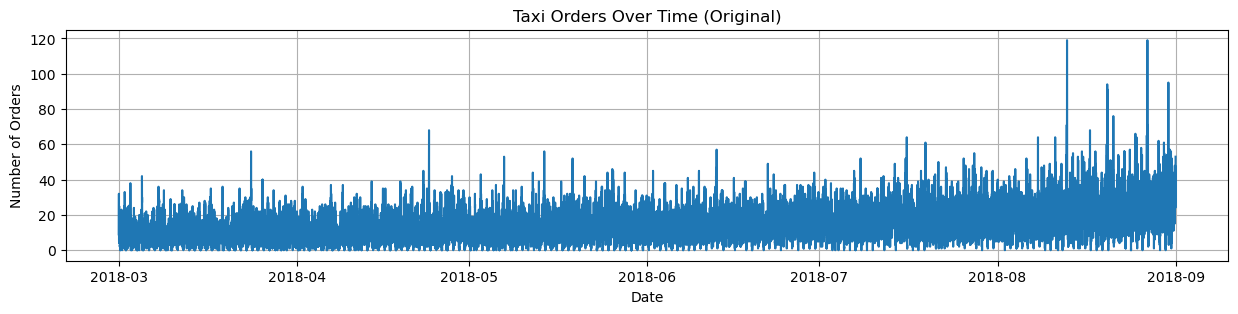

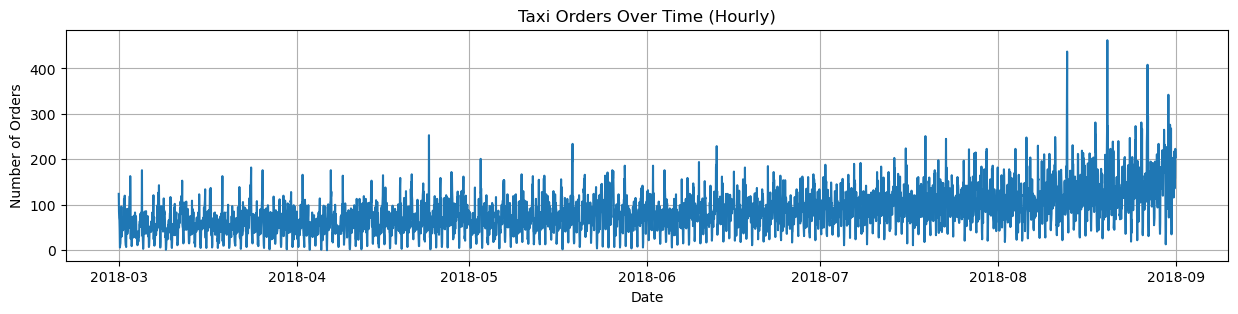

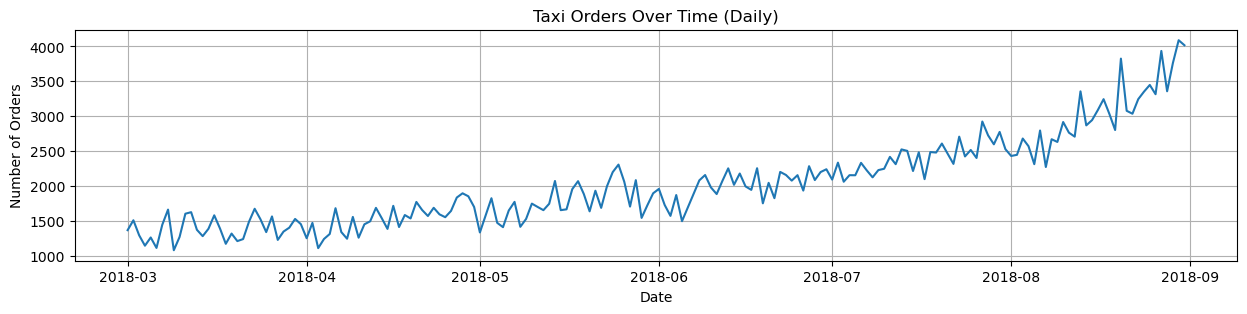

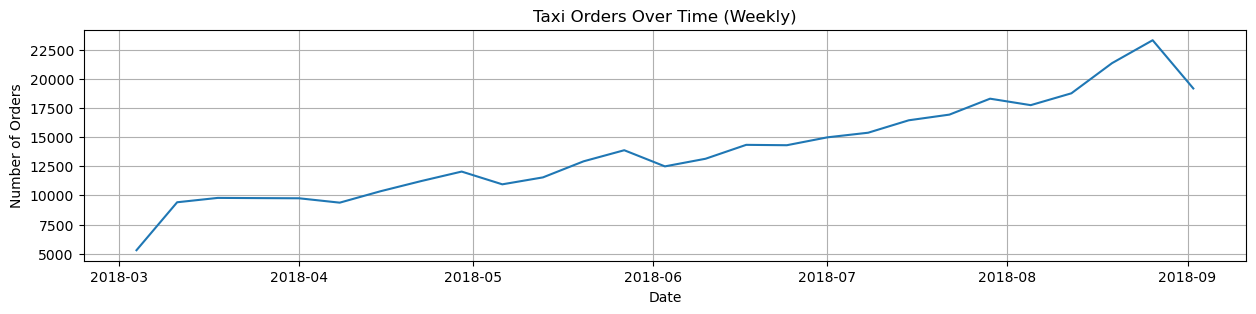

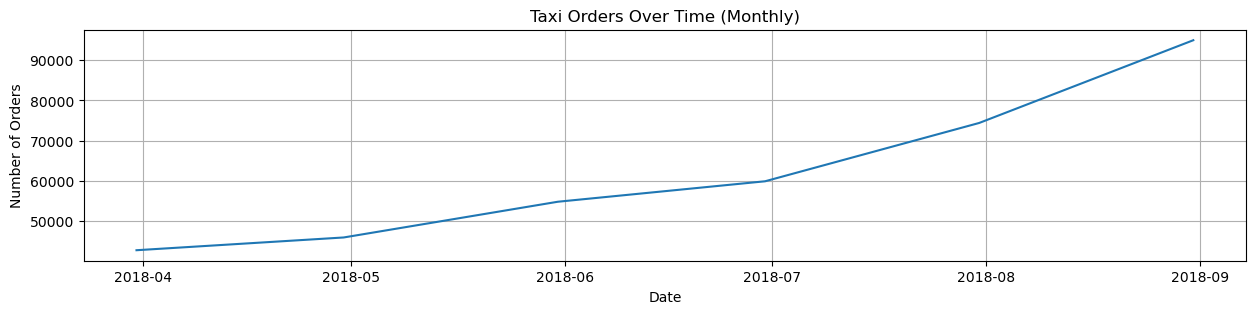

In [4]:
# Plot the original time series
plt.figure(figsize=(15,3))
plt.plot(data.index, data['num_orders'])
plt.title('Taxi Orders Over Time (Original)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

# Plot the hourly resampled data
plt.figure(figsize=(15,3))
plt.plot(hourly_data.index, hourly_data['num_orders'])
plt.title('Taxi Orders Over Time (Hourly)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

# Plot the daily resampled data
daily_data = data.resample('1D').sum()
plt.figure(figsize=(15,3))
plt.plot(daily_data.index, daily_data['num_orders'])
plt.title('Taxi Orders Over Time (Daily)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

# Plot the weekly resampled data
weekly_data = data.resample('1W').sum()
plt.figure(figsize=(15,3))
plt.plot(weekly_data.index, weekly_data['num_orders'])
plt.title('Taxi Orders Over Time (Weekly)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

# Plot the monthly resampled data
monthly_data = data.resample('1M').sum()
plt.figure(figsize=(15,3))
plt.plot(monthly_data.index, monthly_data['num_orders'])
plt.title('Taxi Orders Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

Multi-frequency visualizations reveal patterns at different time scales: hourly data shows daily cycles, daily views expose weekly patterns, and weekly/monthly aggregations highlight seasonal trends and a gradual upward trajectory. These complementary perspectives inform our feature selection and modeling strategy.

Let's Decompose the time series to also analyze the seasonality and trends in the data:

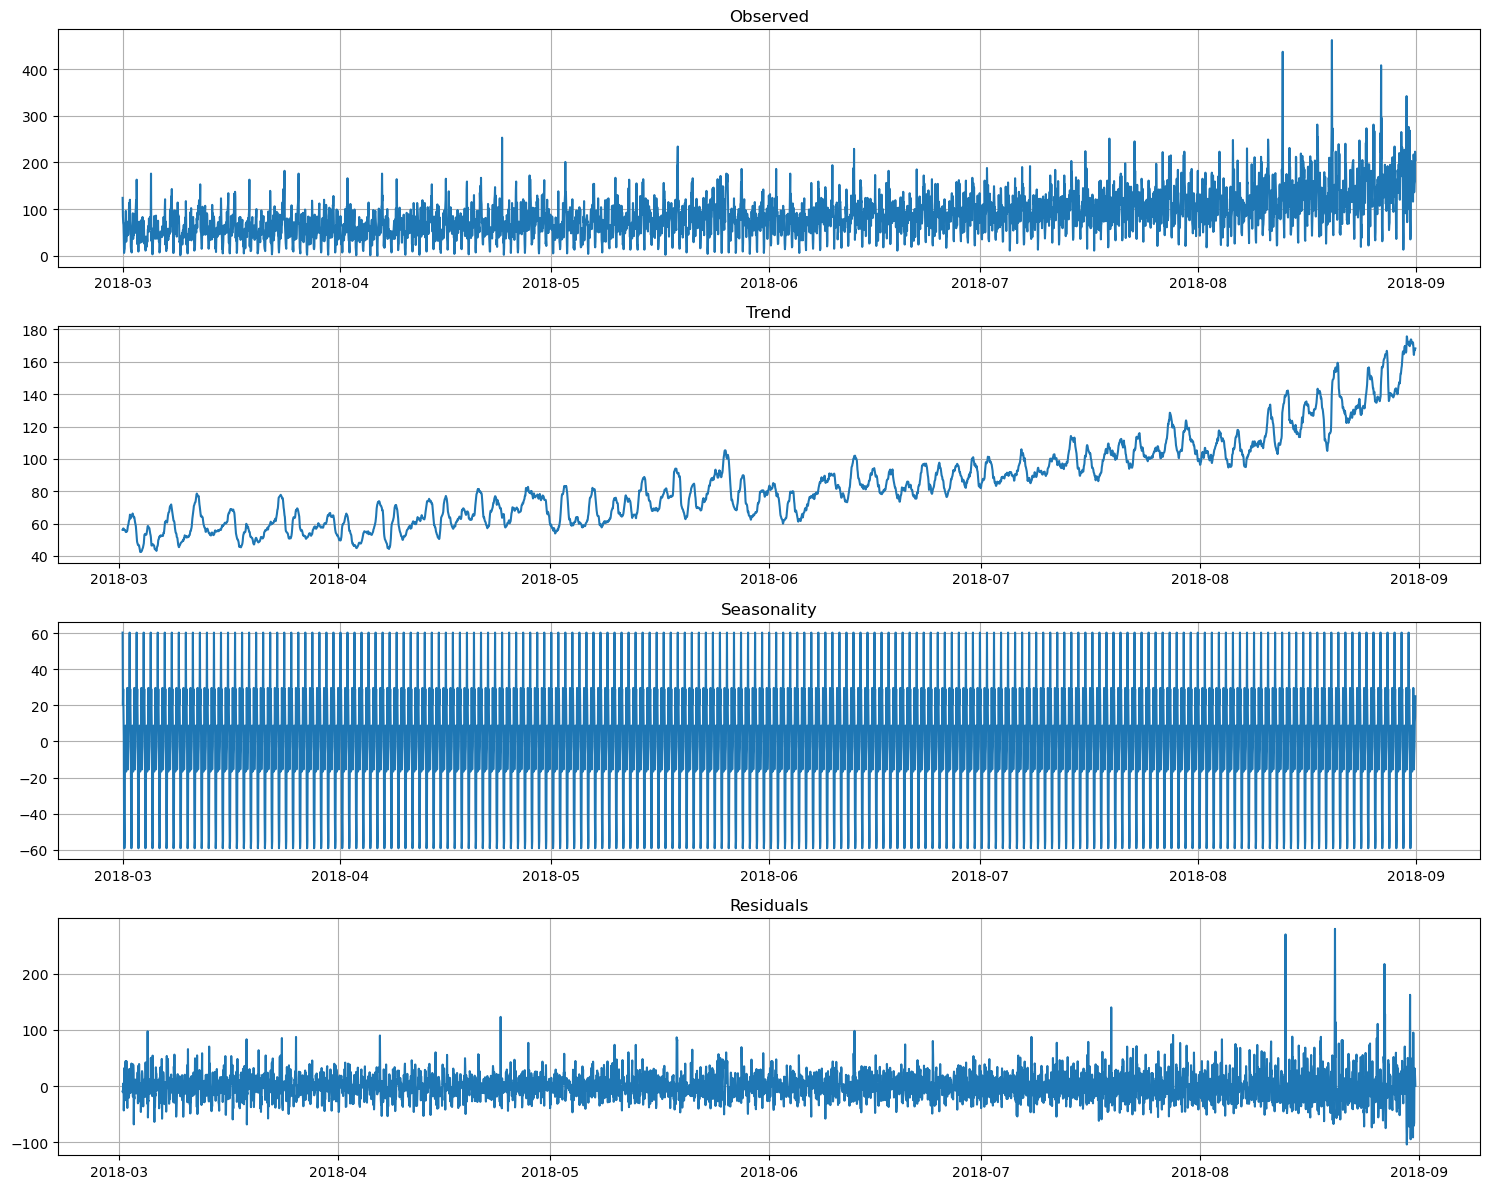

In [5]:
# Decompose the time series to observe trend, seasonality, and residuals
decomposition = seasonal_decompose(hourly_data, model='additive', period=24)  # 24 hours for daily seasonality

# Plot the decomposition
plt.figure(figsize=(15, 12))

plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Observed')
plt.grid(True)

plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.grid(True)

plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonality')
plt.grid(True)

plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()

Decomposition breaks our data into three components: an upward trend indicating growing demand, strong 24-hour seasonality showing predictable daily cycles, and mostly random residuals with some structure. This analysis confirms the presence of clear patterns while identifying remaining unexplained variations requiring further modeling.

Let's also check for autocorrelation and partial autocorrelation to understand the time series dependencies:

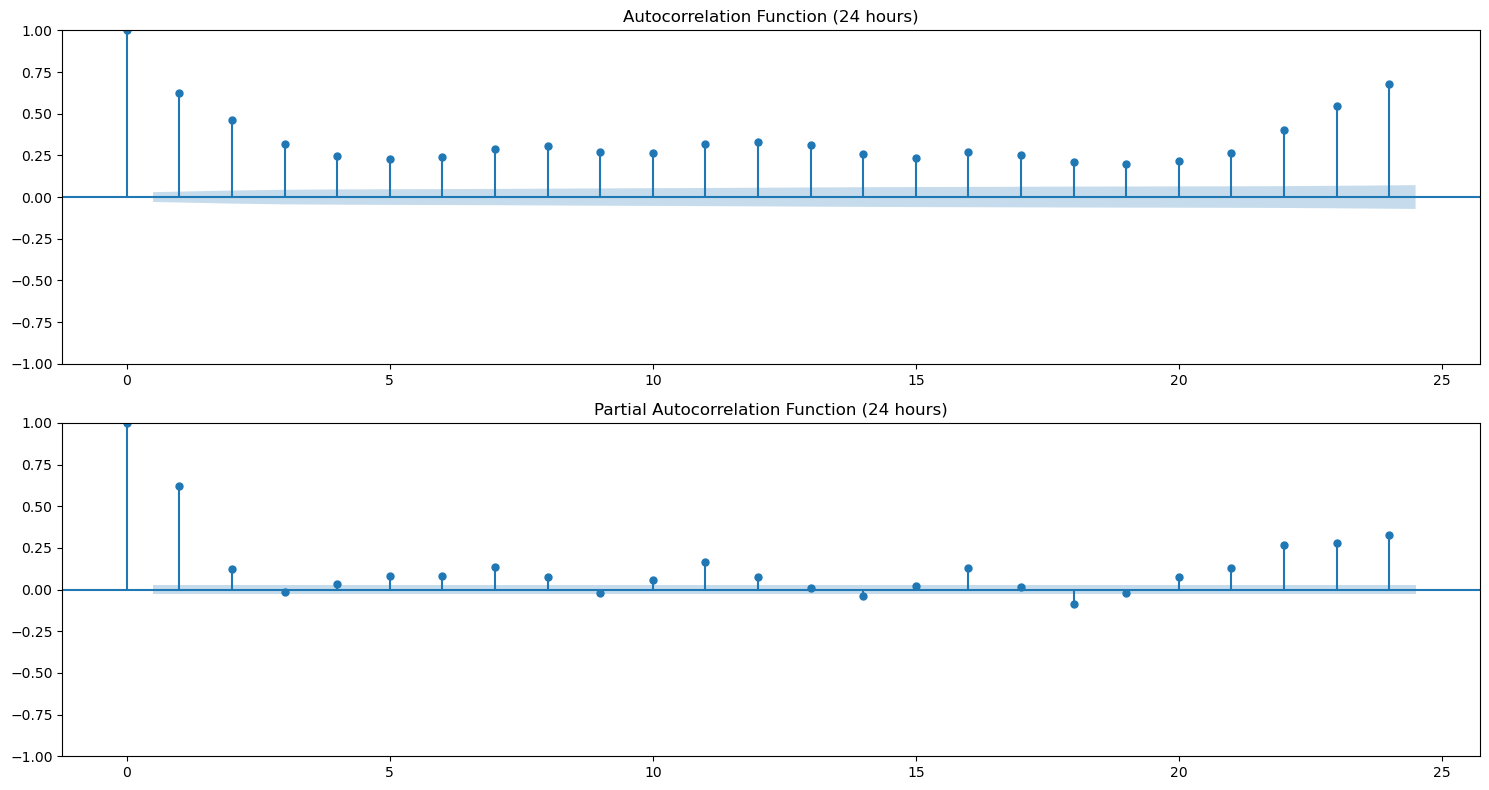

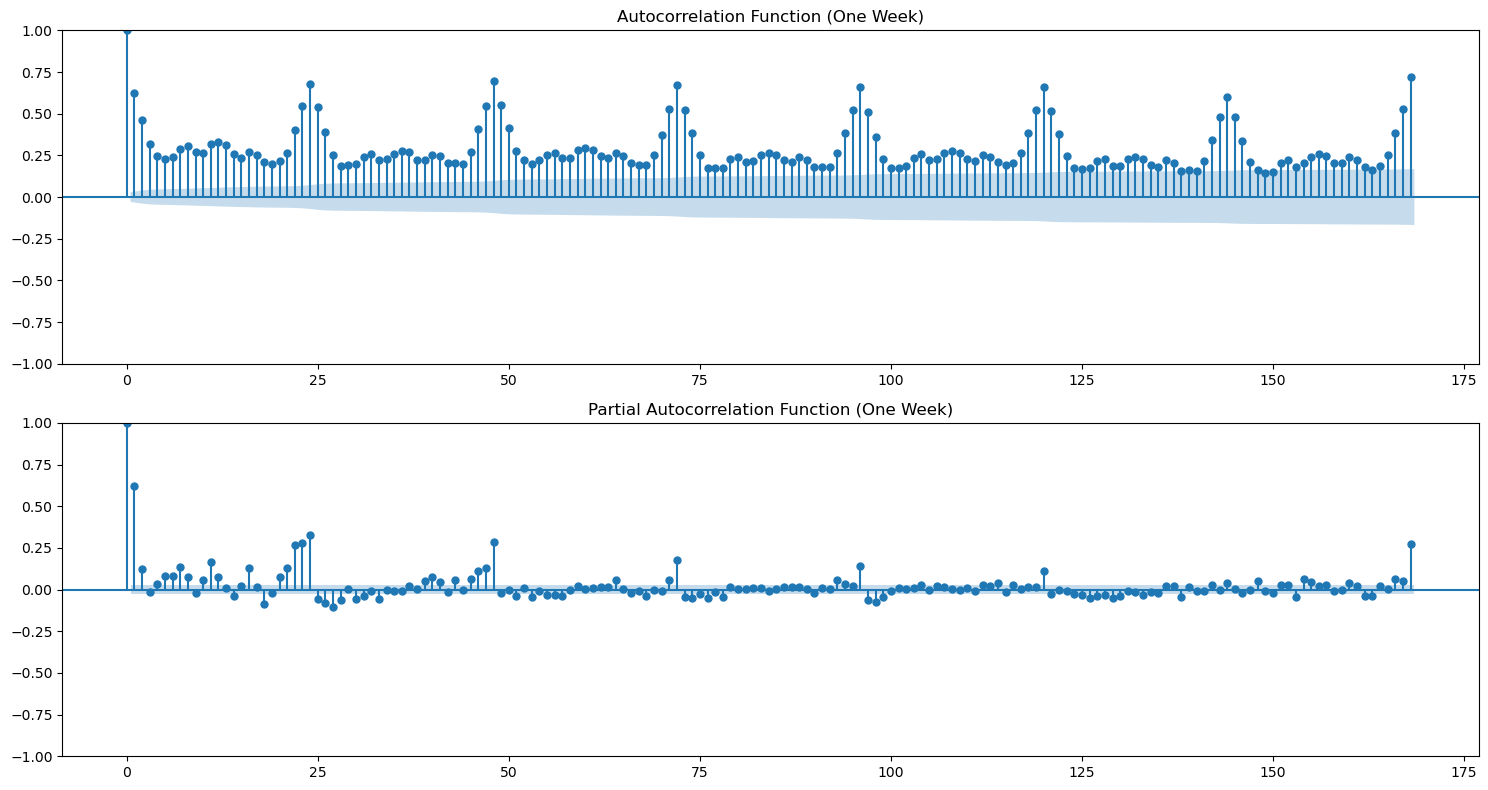

In [6]:
# Plot ACF and PACF with 24 hours lag
plt.figure(figsize=(15, 8))

plt.subplot(211)
plot_acf(hourly_data, ax=plt.gca(), lags=24)
plt.title('Autocorrelation Function (24 hours)')

plt.subplot(212)
plot_pacf(hourly_data, ax=plt.gca(), lags=24)
plt.title('Partial Autocorrelation Function (24 hours)')

plt.tight_layout()
plt.show()

# Plot one week ACF and PACF with hourly lags (168 hours)
plt.figure(figsize=(15, 8))

plt.subplot(211)
plot_acf(hourly_data, ax=plt.gca(), lags=168)  # 168 hours = 1 week
plt.title('Autocorrelation Function (One Week)')

plt.subplot(212)
plot_pacf(hourly_data, ax=plt.gca(), lags=168)  # 168 hours = 1 week
plt.title('Partial Autocorrelation Function (One Week)')

plt.tight_layout()
plt.show()

The ACF plot reveals strong seasonal patterns at both daily (24-hour) and weekly (168-hour) intervals, with significant spikes occurring at multiples of 24 hours. The gradual decay in autocorrelation confirms the non-stationary nature of the data. The PACF plot shows significant direct relationships at short lags (1-3 hours) and distinct spikes at 24 and 168 hours, indicating both daily and weekly cyclical patterns. These patterns suggest that taxi demand follows predictable weekly cycles where the same hour on the same day of the week is a strong predictor of future demand, informing our model selection to incorporate these multi-period seasonalities.

Let's also explore some additional patterns in the data:

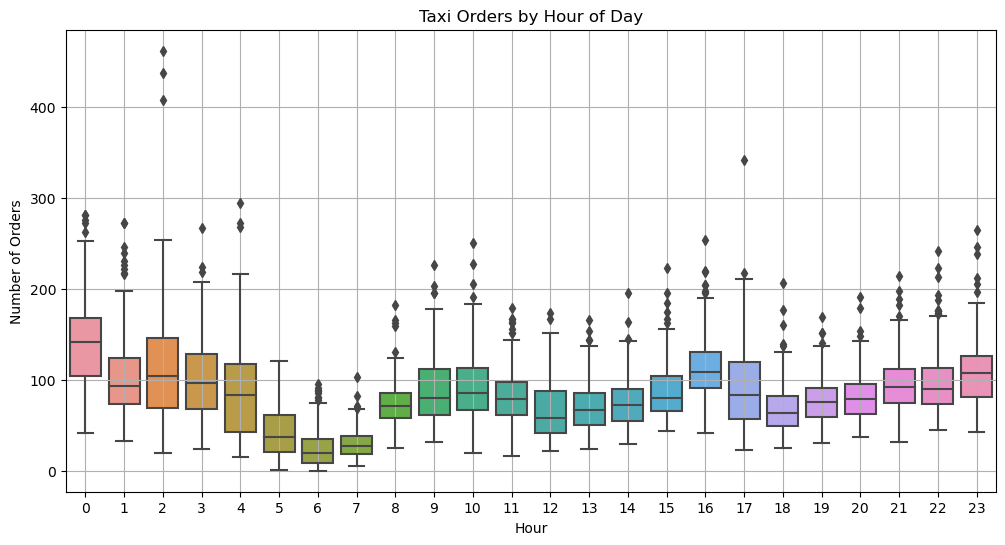

Top 3 hours by average orders:
hour
0     144.4
16    114.1
2     113.1
Name: num_orders, dtype: float64

Bottom 3 hours by average orders:
hour
6    25.2
7    29.3
5    42.6
Name: num_orders, dtype: float64


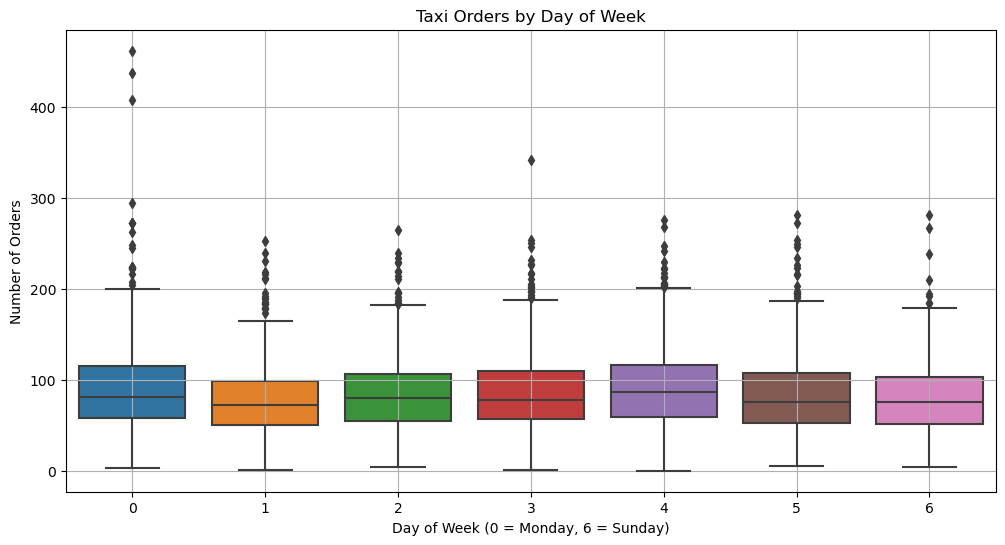

Average orders by day of week (0=Mon, 6=Sun):
day_of_week
0    90.2
1    77.0
2    83.8
3    85.7
4    91.1
5    83.8
6    79.0
Name: num_orders, dtype: float64


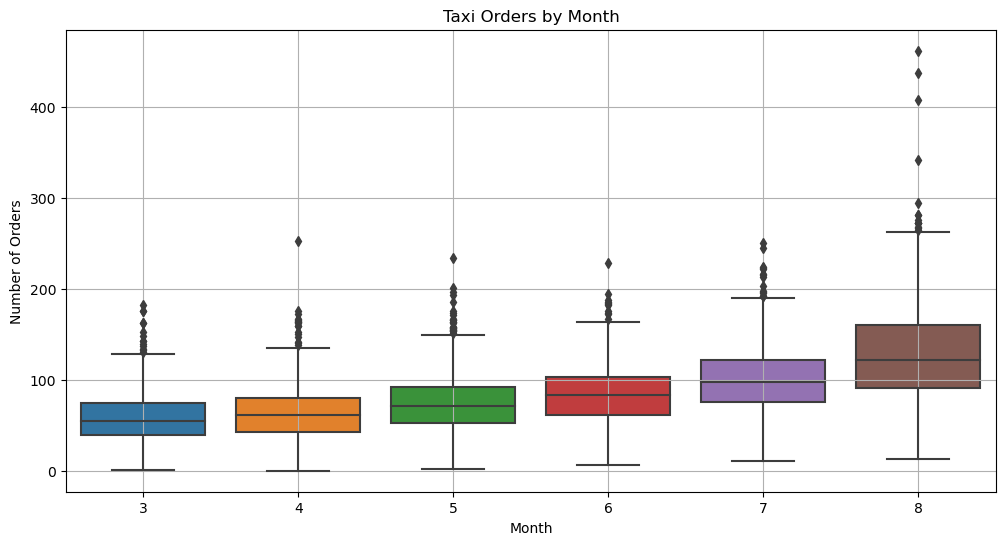

Average orders by month:
month
3     57.5
4     63.8
5     73.7
6     83.2
7    100.0
8    127.7
Name: num_orders, dtype: float64


In [7]:
# Extract hour of day, day of week, day of month and month to analyze patterns
hourly_data['hour'] = hourly_data.index.hour
hourly_data['day_of_week'] = hourly_data.index.dayofweek
hourly_data['day_of_month'] = hourly_data.index.day
hourly_data['month'] = hourly_data.index.month

# Analyze orders by hour of day
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='num_orders', data=hourly_data)
plt.title('Taxi Orders by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

# Add simple hourly summary
hourly_means = hourly_data.groupby('hour')['num_orders'].mean().round(1)
print("Top 3 hours by average orders:")
print(hourly_means.nlargest(3))
print("\nBottom 3 hours by average orders:")
print(hourly_means.nsmallest(3))

# Analyze orders by day of week (0 = Monday, 6 = Sunday)
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='num_orders', data=hourly_data)
plt.title('Taxi Orders by Day of Week')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

# Add simple day of week summary
dow_means = hourly_data.groupby('day_of_week')['num_orders'].mean().round(1)
print("Average orders by day of week (0=Mon, 6=Sun):")
print(dow_means)

# Analyze orders by month
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='num_orders', data=hourly_data)
plt.title('Taxi Orders by Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

# Add simple monthly summary
month_means = hourly_data.groupby('month')['num_orders'].mean().round(1)
print("Average orders by month:")
print(month_means)

The taxi order data reveals distinct temporal patterns across multiple time scales:

* **Hourly trends**: Highest demand at midnight (144.4 orders) and 4pm (114.1); lowest during early morning hours (25.2 orders at 6am)
* **Weekly patterns**: Relatively consistent across days, with modest peaks on Fridays (91.1) and Mondays (90.2)
* **Monthly progression**: Strong upward trend from March (57.5) to August (127.7), indicating significant business growth rather than seasonal variation

Finally, let's check for stationarity of the time series using the Augmented Dickey-Fuller test:

In [8]:
# Perform ADF test for stationarity
adf_result = adfuller(hourly_data['num_orders'].dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# Interpret the result
if adf_result[1] <= 0.05:
    print("\nThe time series is stationary.")
else:
    print("\nThe time series is not stationary.")

ADF Statistic: -3.068924289027932
p-value: 0.02894005140261486
Critical Values:
   1%: -3.431842162413052
   5%: -2.8621993540813637
   10%: -2.567120978470452

The time series is stationary.


The Augmented Dickey-Fuller test results (ADF statistic: -3.07, p-value: 0.029) indicate the hourly taxi order data is stationary at the 5% significance level. With the p-value below 0.05 and the ADF statistic more negative than the critical value at 5% (-2.86), we reject the null hypothesis of a unit root, confirming the absence of a strong trend component that would require differencing before modeling.

This result is somewhat surprising given the visible upward trend in the monthly data, suggesting that while there is growth over the months, the hourly patterns may be stable enough that the series passes stationarity tests. This could mean:

The hourly and daily seasonality patterns are stronger than the upward trend
The resampling to hourly data may have helped stabilize the series
The cyclical components have been effectively captured in the hourly structure

For modeling implications, this suggests we may be able to use standard ARIMA models without differencing, though incorporating seasonal components will still be important to capture the daily and weekly patterns identified in our previous analysis.

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Everything above is correct. Great work!

</div>

## **1.2 Data Preparation**
Let's now prepare our data for modeling. We'll:

- Split the data into train, validation, and test sets (70/20/10 split)
- Create time-based features
- Generate lag features and rolling statistics
- Check for any missing values that might need handling

Dataset shape: (4416, 5)

First few rows:
                     num_orders  hour  day_of_week  day_of_month  month
datetime                                                               
2018-03-01 00:00:00         124     0            3             1      3
2018-03-01 01:00:00          85     1            3             1      3
2018-03-01 02:00:00          71     2            3             1      3
2018-03-01 03:00:00          66     3            3             1      3
2018-03-01 04:00:00          43     4            3             1      3

Last few rows:
                     num_orders  hour  day_of_week  day_of_month  month
datetime                                                               
2018-08-31 19:00:00         136    19            4            31      8
2018-08-31 20:00:00         154    20            4            31      8
2018-08-31 21:00:00         159    21            4            31      8
2018-08-31 22:00:00         223    22            4            31      8
2018-0

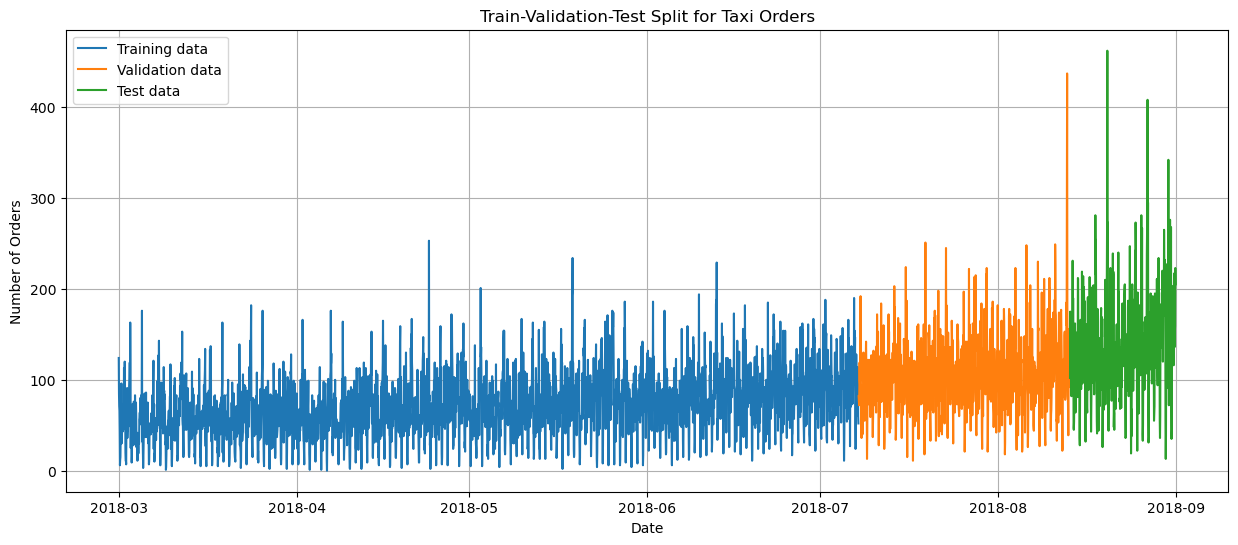

In [9]:
# 1.1 Verify our dataframe is properly setup with datetime index
print("Dataset shape:", hourly_data.shape)
print("\nFirst few rows:")
print(hourly_data.head())
print("\nLast few rows:")
print(hourly_data.tail())

# 1.2 Time-based train-validation-test split (70/20/10)
train_data = hourly_data[:int(len(hourly_data)*0.7)]  # First 70% of timeline
val_data = hourly_data[int(len(hourly_data)*0.7):int(len(hourly_data)*0.9)]  # Next 20%
test_data = hourly_data[int(len(hourly_data)*0.9):]  # Final 10%

print("\nData split sizes:")
print(f"Training set: {len(train_data)} observations ({train_data.index[0]} to {train_data.index[-1]})")
print(f"Validation set: {len(val_data)} observations ({val_data.index[0]} to {val_data.index[-1]})")
print(f"Test set: {len(test_data)} observations ({test_data.index[0]} to {test_data.index[-1]})")

# 1.3 Visualize the train-validation-test split
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data['num_orders'], label='Training data')
plt.plot(val_data.index, val_data['num_orders'], label='Validation data')
plt.plot(test_data.index, test_data['num_orders'], label='Test data')
plt.title('Train-Validation-Test Split for Taxi Orders')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Correct

</div>

In [10]:
def create_features(df):
    """
    Creates additional time series features beyond the basic ones we already extracted
    """
    df = df.copy()
    
    # Cyclical encoding for hour and day of week (to capture cyclical nature)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)
    
    # Is weekend feature
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Add lag features based on our ACF/PACF analysis
    df['lag_1h'] = df['num_orders'].shift(1)
    df['lag_2h'] = df['num_orders'].shift(2)
    df['lag_3h'] = df['num_orders'].shift(3)
    df['lag_24h'] = df['num_orders'].shift(24)  # Same hour yesterday
    df['lag_168h'] = df['num_orders'].shift(168)  # Same hour last week
    
    # First shift the data to avoid target leakage, then calculate rolling features
    shifted_series = df['num_orders'].shift(1)
    
    # Add rolling window features using the shifted data
    df['rolling_mean_6h'] = shifted_series.rolling(window=6).mean()
    df['rolling_mean_12h'] = shifted_series.rolling(window=12).mean()
    df['rolling_mean_24h'] = shifted_series.rolling(window=24).mean()
    
    # Add rolling standard deviation (volatility) using the shifted data
    df['rolling_std_24h'] = shifted_series.rolling(window=24).std()
    
    # Add trend feature
    df['trend'] = np.arange(len(df))
    
    return df

# 1.5 Apply feature engineering to all datasets
train_features = create_features(train_data)
val_features = create_features(val_data)
test_features = create_features(test_data)

# 1.6 Check for missing values caused by lag features
print("\nMissing values in training set:")
print(train_features.isna().sum().sort_values(ascending=False)[:10])  # Show top 10 columns with missing values

# 1.7 Handle missing values - for lag features we'll drop the rows with NAs
# This is fine since we're only losing the first few rows in the training set
train_features = train_features.dropna()
val_features = val_features.dropna()
test_features = test_features.dropna()

print("\nFeature-engineered datasets after handling missing values:")
print(f"Training set: {train_features.shape}")
print(f"Validation set: {val_features.shape}")
print(f"Test set: {test_features.shape}")

# 1.8 Show a sample of the feature-engineered data
print("\nSample of feature-engineered data:")
display(train_features.head())


Missing values in training set:
lag_168h            168
rolling_std_24h      24
rolling_mean_24h     24
lag_24h              24
rolling_mean_12h     12
rolling_mean_6h       6
lag_3h                3
lag_2h                2
lag_1h                1
hour                  0
dtype: int64

Feature-engineered datasets after handling missing values:
Training set: (2923, 20)
Validation set: (715, 20)
Test set: (274, 20)

Sample of feature-engineered data:


,num_orders,hour,day_of_week,day_of_month,month,hour_sin,hour_cos,dow_sin,dow_cos,is_weekend,lag_1h,lag_2h,lag_3h,lag_24h,lag_168h,rolling_mean_6h,rolling_mean_12h,rolling_mean_24h,rolling_std_24h,trend
datetime,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,3,8,3,0.000000,1.000000,0.433884,-0.900969,0,94.0,127.0,108.0,100.0,124.0,92.333333,69.250000,60.041667,33.200942,168
2018-03-08 01:00:00,78,1,3,8,3,0.258819,0.965926,0.433884,-0.900969,0,143.0,94.0,127.0,121.0,85.0,99.666667,78.333333,61.833333,36.452073,169
2018-03-08 02:00:00,65,2,3,8,3,0.500000,0.866025,0.433884,-0.900969,0,78.0,143.0,94.0,24.0,71.0,104.333333,80.250000,60.041667,34.417487,170
2018-03-08 03:00:00,68,3,3,8,3,0.707107,0.707107,0.433884,-0.900969,0,65.0,78.0,143.0,66.0,66.0,102.500000,82.083333,61.750000,33.557543,171
2018-03-08 04:00:00,60,4,3,8,3,0.866025,0.500000,0.433884,-0.900969,0,68.0,65.0,78.0,73.0,43.0,95.833333,83.500000,61.833333,33.571037,172


<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

You have a target leakage here. You should apply method .shift() before to apply method .rolling() to exclude current observations from moving windows.

</div>

<div class="alert alert-info">
Fixed
</div>

# **3. Training**

## **3.1 Modeling Pipeline - Evaluation Framework & Baseline Models**

In this section, we'll establish our evaluation framework and train our baseline models. 

A good baseline provides context for more complex models and helps us understand the minimum performance we should expect. We'll:

- Create a robust evaluation function that calculates multiple metrics (RMSE, MAE, MAPE, R2 score)
- Implement a persistency model (using previous day's value) as a simple baseline
- Train a linear regression model as our statistical baseline

The evaluation framework will be used consistently across all models to ensure fair comparisons.


In [11]:
# 2.1 Create the evaluation function
def evaluate_model(y_true, y_pred, model_name):
    """Evaluates model predictions using multiple metrics"""
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Add MAPE (handling zero values to avoid division by zero)
    y_true_safe = np.where(y_true > 0, y_true, 1)  # Replace zeros with ones
    mape = np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100
    
    # Add R² score
    r2 = r2_score(y_true, y_pred)

    print(f"Model: {model_name}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")
    print("-" * 40)
    
    return {
        'Model': model_name,
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2),
        'MAPE (%)': round(mape, 2),
        'R²': round(r2, 4)
    }

# 2.2 Create list to store validation results
validation_results = []

Training Persistence Model...
Model: Persistence Model (24h)
RMSE: 38.53
MAE: 29.36
MAPE: 31.52%
R²: 0.1411
----------------------------------------


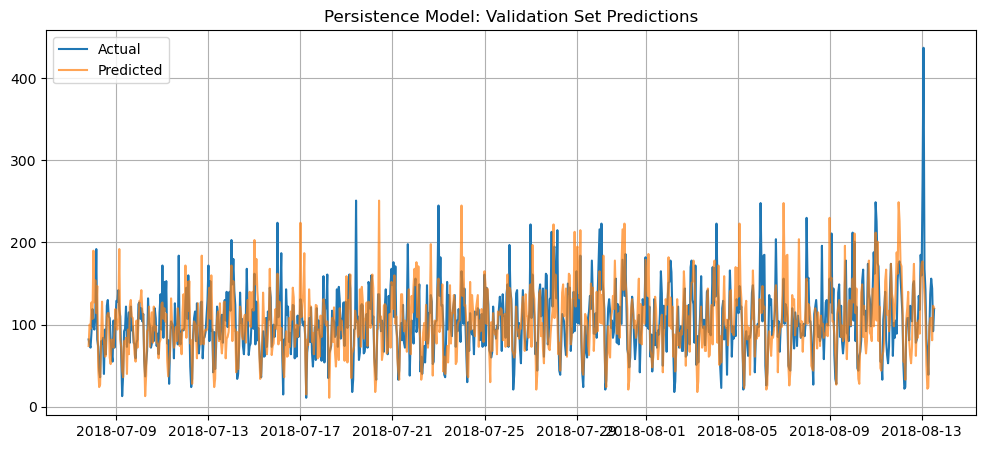

In [12]:
# 2.3 Baseline Model 1: Persistence Model
def persistence_model(train_data, val_data):
    """Simple persistence model using 24-hour lag"""
    # For each validation point, use the value from 24 hours before
    val_pred = []
    
    for i in range(len(val_data)):
        current_idx = val_data.index[i]
        lagged_idx = current_idx - pd.Timedelta(hours=24)
        
        if lagged_idx in train_data.index:
            val_pred.append(train_data.loc[lagged_idx, 'num_orders'])
        elif lagged_idx in val_data.index:
            val_pred.append(val_data.loc[lagged_idx, 'num_orders'])
        else:
            # Use previous value if lag not available
            val_pred.append(val_data.iloc[max(0, i-1)]['num_orders'])
    
    # Evaluate on validation data
    val_metrics = evaluate_model(val_data['num_orders'].values, np.array(val_pred), "Persistence Model (24h)")
    
    # Visualize predictions
    plt.figure(figsize=(12, 5))
    plt.plot(val_data.index, val_data['num_orders'], label='Actual')
    plt.plot(val_data.index, val_pred, label='Predicted', alpha=0.7)
    plt.title('Persistence Model: Validation Set Predictions')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return val_metrics

# Run the baseline model
print("Training Persistence Model...")
persistence_val = persistence_model(train_data, val_data)
validation_results.append(persistence_val)



Training Linear Regression Model...
Model: Linear Regression
RMSE: 34.44
MAE: 25.52
MAPE: 28.46%
R²: 0.3580
----------------------------------------


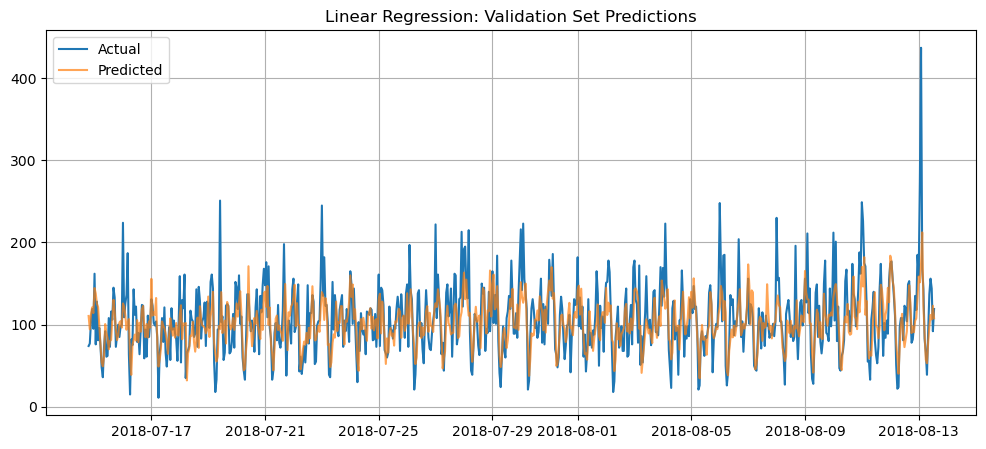

Linear Regression Coefficients:
            Feature  Coefficient
1          hour_cos     2.534975
3           lag_24h     0.446906
2            lag_1h     0.287089
4  rolling_mean_24h     0.147048
0          hour_sin    -4.441378

Baseline Model Comparison:
                     Model   RMSE    MAE  MAPE (%)      R²
0  Persistence Model (24h)  38.53  29.36     31.52  0.1411
1        Linear Regression  34.44  25.52     28.46  0.3580


In [13]:
# 2.4 Baseline Model 2: Linear Regression
def train_linear_regression(train_features, val_features):
    """Trains a simple linear regression with key features"""
    # Select a small subset of relevant features
    features = ['hour_sin', 'hour_cos', 'lag_1h', 'lag_24h', 'rolling_mean_24h']
    
    # Prepare the data
    X_train = train_features[features]
    y_train = train_features['num_orders']
    
    X_val = val_features[features]
    y_val = val_features['num_orders']
    
    # Train the model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Make predictions
    val_pred = lr_model.predict(X_val)
    
    # Evaluate on validation data
    val_metrics = evaluate_model(y_val, val_pred, "Linear Regression")
    
    # Visualize predictions
    plt.figure(figsize=(12, 5))
    plt.plot(val_features.index, y_val, label='Actual')
    plt.plot(val_features.index, val_pred, label='Predicted', alpha=0.7)
    plt.title('Linear Regression: Validation Set Predictions')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print feature importance
    coefficients = pd.DataFrame({
        'Feature': features,
        'Coefficient': lr_model.coef_
    }).sort_values('Coefficient', ascending=False)
    
    print("Linear Regression Coefficients:")
    print(coefficients)
    
    return val_metrics

# Run the Linear Regression model
print("\nTraining Linear Regression Model...")
lr_val = train_linear_regression(train_features, val_features)
validation_results.append(lr_val)

# Display validation results table
results_df = pd.DataFrame(validation_results)
print("\nBaseline Model Comparison:")
print(results_df)

Our baseline models provide encouraging initial results. The simple persistence model achieves an RMSE of 38.53, already below our project requirement of 48. The linear regression model performs even better with an RMSE of 34.44, indicating the value of incorporating cyclical time patterns and recent demand history. The linear regression coefficients reveal that hour of day (through sine/cosine encoding) strongly influences predictions, with substantial contributions from previous day's demand (lag_24h) and previous hour's demand (lag_1h). These results establish a solid foundation for comparison as we move toward more sophisticated models.

## **3.2 Time Series Models: ARIMA & SARIMA**
Time series models are specifically designed to capture temporal dependencies and seasonal patterns in sequential data. In this section, we'll implement:

1. **ARIMA** (AutoRegressive Integrated Moving Average) 
- models that capture trend and autocorrelation patterns
2. **SARIMA** (Seasonal ARIMA) 
- models that additionally model the daily cyclical patterns we observed

We'll use the `pmdarima` library's `auto_arima` function to automatically identify optimal model parameters through a grid search approach. This will help us find the best combination of:

- p (autoregressive order)
- d (differencing degree)
- q (moving average order)
- P, D, Q (seasonal components)
- m (seasonal period)

Let's train these specialized time series models and compare their performance to our baselines.

Training ARIMA Model...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=35742.408, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=30287.917, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=33364.323, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=30061.316, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=30019.766, Time=0.11 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=29991.474, Time=0.31 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=29915.296, Time=0.30 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=1.86 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=1.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=29570.367, Time=0.45 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=29572.393, Time=0.28 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=29572.366, Time=0.88 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=29574.349, Time=0.62 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0] intercept
Total fit time: 6.393 secon

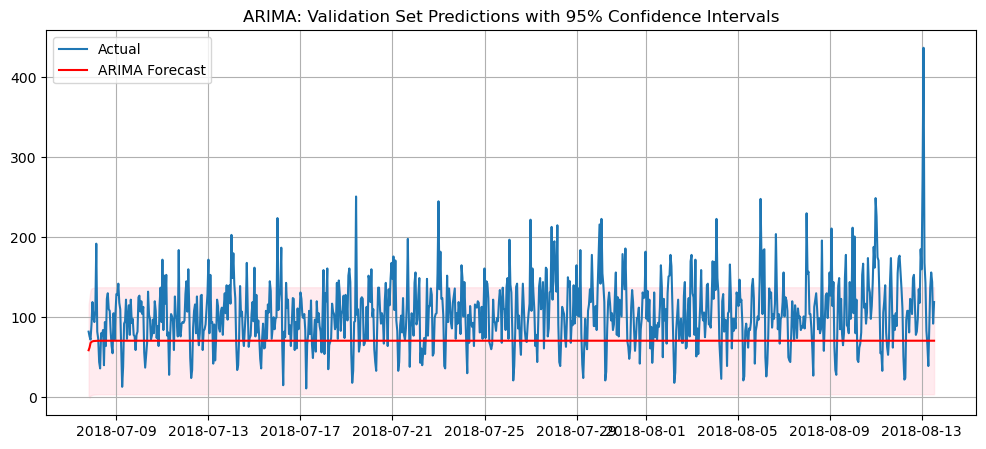

Training SARIMA Model...
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=29579.327, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=30599.196, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=28624.839, Time=9.27 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=29294.138, Time=6.03 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=35742.408, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=29595.854, Time=0.15 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=87.72 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=22.89 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=29068.294, Time=9.63 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=27732.907, Time=103.55 sec
 ARIMA(1,0,0)(2,0,2)[24] intercept   : AIC=inf, Time=95.83 sec
 ARIMA(1,0,0)(1,0,2)[24] intercept   : AIC=27626.894, Time=96.83 sec
 ARIMA(1,0,0)(0,0,2)[24] intercept   : AIC=28725.834, Time=36.26 sec
 ARIMA(0,0,0)(1,0,2)[24] intercept   : AIC=28064.159, Time=

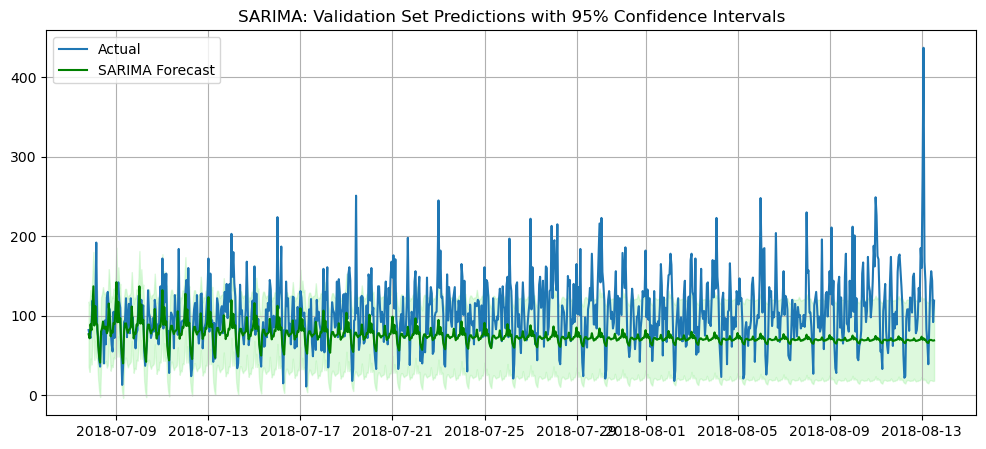


Model Comparison (including Time Series models):
                     Model   RMSE    MAE  MAPE (%)      R²
1        Linear Regression  34.44  25.52     28.46  0.3580
0  Persistence Model (24h)  38.53  29.36     31.52  0.1411
3            SARIMA (m=24)  49.03  36.37     33.60 -0.3910
2                    ARIMA  54.00  41.64     39.66 -0.6874


In [14]:
# 3.2 Train ARIMA model
def train_arima(train_data, val_data):
    """Trains an ARIMA model using auto_arima for parameter selection"""
    print("Training ARIMA Model...")
    
    # Fit auto_arima model to determine optimal parameters
    # Start with non-seasonal model
    arima_model = pm.auto_arima(
        train_data['num_orders'],
        start_p=0, start_q=0,
        max_p=5, max_q=5,
        d=None,  # Auto-determine differencing
        test='adf',
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore',
        max_order=None,
        trace=True  # Print model evaluation results
    )
    
    # Summary of the best model
    print(arima_model.summary())
    
    # Forecast on validation set
    n_periods = len(val_data)
    forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)
    
    # Evaluate on validation data
    val_metrics = evaluate_model(val_data['num_orders'].values, forecast, "ARIMA")
    
    # Plot predictions with confidence intervals
    plt.figure(figsize=(12, 5))
    plt.plot(val_data.index, val_data['num_orders'], label='Actual')
    plt.plot(val_data.index, forecast, label='ARIMA Forecast', color='red')
    plt.fill_between(val_data.index, 
                     conf_int[:, 0], conf_int[:, 1], 
                     color='pink', alpha=0.3)
    plt.title('ARIMA: Validation Set Predictions with 95% Confidence Intervals')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return val_metrics, arima_model

# 3.3 Train SARIMA model
def train_sarima(train_data, val_data):
    """Trains a Seasonal ARIMA model with daily seasonality"""
    print("Training SARIMA Model...")
    
    # Fit auto_arima model with seasonality
    sarima_model = pm.auto_arima(
        train_data['num_orders'],
        start_p=1, start_q=1,
        max_p=3, max_q=3,
        d=None,  # Auto-determine differencing
        test='adf',
        seasonal=True,  # Enable seasonality
        m=24,  # Daily seasonality (24 hours)
        start_P=0, start_Q=0,
        max_P=2, max_Q=2,
        D=None,  # Auto-determine seasonal differencing
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore',
        max_order=None,
        trace=True  # Print model evaluation results
    )
    
    # Summary of the best model
    print(sarima_model.summary())
    
    # Forecast on validation set
    n_periods = len(val_data)
    forecast, conf_int = sarima_model.predict(n_periods=n_periods, return_conf_int=True)
    
    # Evaluate on validation data
    val_metrics = evaluate_model(val_data['num_orders'].values, forecast, "SARIMA (m=24)")
    
    # Plot predictions with confidence intervals
    plt.figure(figsize=(12, 5))
    plt.plot(val_data.index, val_data['num_orders'], label='Actual')
    plt.plot(val_data.index, forecast, label='SARIMA Forecast', color='green')
    plt.fill_between(val_data.index, 
                     conf_int[:, 0], conf_int[:, 1], 
                     color='lightgreen', alpha=0.3)
    plt.title('SARIMA: Validation Set Predictions with 95% Confidence Intervals')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return val_metrics, sarima_model

# Run ARIMA and SARIMA models
arima_val, arima_model = train_arima(train_data, val_data)
validation_results.append(arima_val)

sarima_val, sarima_model = train_sarima(train_data, val_data)
validation_results.append(sarima_val)

# Update and display validation results table
results_df = pd.DataFrame(validation_results)
print("\nModel Comparison (including Time Series models):")
print(results_df.sort_values('RMSE'))

## **Time Series Models Evaluation**
The ARIMA and SARIMA models, despite their specialized design for time series data, underperformed compared to our simpler baseline approaches. This analysis explores why and what we can learn from these results.

### ARIMA Model Analysis

* The optimal ARIMA(5,0,0) configuration included:
  * 5 autoregressive terms with the strongest influence from the most recent hour (coefficient 0.49)
  * No differencing needed (confirming our stationarity test results)
  * An intercept term of 31.64

* **Key limitations**:
  * Failed to account for daily seasonality (24-hour cycles)
  * Could not capture weekly patterns
  * Treated each point as dependent only on the previous 5 hours
  * Showed negative R², indicating worse performance than using the mean value

### SARIMA Model Insights

* The SARIMA(2,0,0)(1,0,[1,2])[24] model correctly identified:
  * Strong 24-hour seasonality (coefficient 0.93 for the same hour yesterday)
  * Modest influence from the previous two hours (coefficients 0.24 and 0.14)
  * Seasonal error corrections from 24 and 48 hours prior

* **Performance issues**:
  * Produced overly conservative predictions that missed the amplitude of daily fluctuations
  * Failed to adapt to the increasing trend in August
  * Still generated a negative R² (-0.3910)
  * Required substantial computation time (1594 seconds)

### Why Simpler Models Performed Better

* **Comprehensive feature engineering in Linear Regression**:
  * Incorporated cyclical encodings for hour of day
  * Combined both short-term (lag_1h) and long-term (lag_24h) dependencies
  * Added smoothed signals through rolling averages
  * Selected features based on domain knowledge from our EDA

* **Structural advantages**:
  * Linear regression directly leveraged multiple different patterns simultaneously
  * Persistence model's simple approach aligned well with the strong 24-hour autocorrelation
  * Our engineered features provided context that automated ARIMA parameter selection missed

### Lessons and Implications

* Domain-specific feature engineering can outperform specialized time series models when based on thorough EDA
* Complexity doesn't guarantee performance - the most sophisticated models delivered the worst results
* Standard time series methods may not adequately capture the multiple patterns present in taxi demand data
* Visual analysis of predictions shows the SARIMA model produced forecasts that were too flat compared to actual values

These results motivate us to explore tree-based machine learning models next, which can potentially capture more complex non-linear relationships in our data while benefiting from our comprehensive feature engineering approach.

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Correct. Good job!

</div>

## **3.3. Machine Learning Models for Time Series Forecasting**
In this section, we'll implement tree-based machine learning models that can capture non-linear patterns in our taxi order data. These models will leverage our comprehensive feature engineering and have the potential to outperform both our baseline and traditional time series approaches. We'll:

1. Train decision tree, random forest, and two gradient boosting models (LightGBM and XGBoost)
2. Evaluate their performance on the validation set
3. Analyze feature importance to understand key drivers of taxi demand
4. Fine-tune the best performing model to further improve accuracy

Tree-based models are particularly well-suited for this problem because they can:

- Handle non-linear relationships between features and target
- Automatically select the most important features
- Capture interactions between different time-based patterns
- Work effectively with our engineered features

Unlike many other machine learning workflows, we will not apply feature scaling to our data. This is appropriate for two key reasons: first, tree-based models make decisions based on thresholds rather than feature magnitudes, making them invariant to monotonic transformations like scaling; second, our engineered features are all derived from the same source variable `[num_orders]` and thus already exist on comparable scales. Since our features share similar ranges and represent related concepts (order counts, lags, and rolling statistics), scaling would add unnecessary complexity without improving model performance.

Training with 19 features: ['hour', 'day_of_week', 'day_of_month', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_weekend', 'lag_1h', 'lag_2h', 'lag_3h', 'lag_24h', 'lag_168h', 'rolling_mean_6h', 'rolling_mean_12h', 'rolling_mean_24h', 'rolling_std_24h', 'trend']
Training Decision Tree Model...
Model: Decision Tree
RMSE: 34.52
MAE: 25.53
MAPE: 26.61%
R²: 0.3549
----------------------------------------

Top 10 Important Features (Decision Tree):
             Feature  Importance
13          lag_168h    0.570694
4           hour_sin    0.103125
12           lag_24h    0.059817
5           hour_cos    0.035193
9             lag_1h    0.034160
14   rolling_mean_6h    0.033838
10            lag_2h    0.025088
18             trend    0.023935
11            lag_3h    0.022782
15  rolling_mean_12h    0.017742


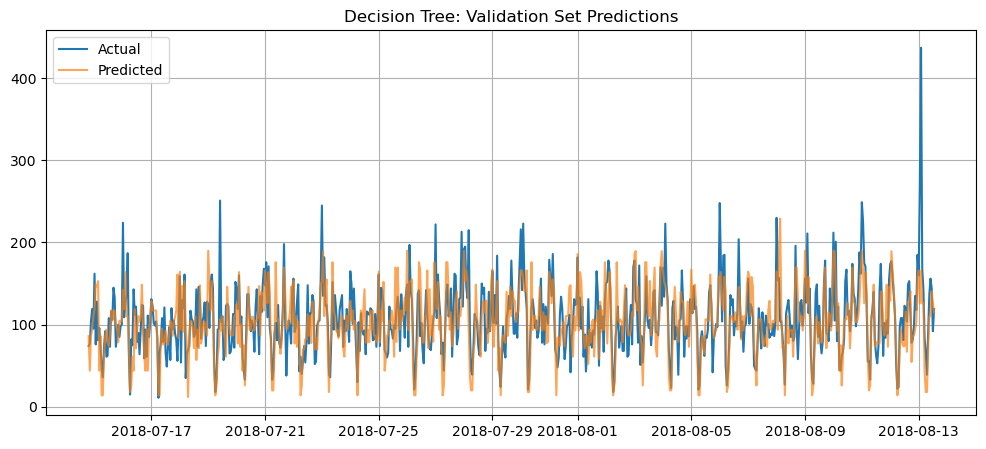

Training Random Forest Model...
Model: Random Forest
RMSE: 29.22
MAE: 21.14
MAPE: 21.77%
R²: 0.5378
----------------------------------------

Top 10 Important Features (Random Forest):
             Feature  Importance
13          lag_168h    0.511219
4           hour_sin    0.099713
12           lag_24h    0.054079
9             lag_1h    0.040005
14   rolling_mean_6h    0.036470
10            lag_2h    0.035887
18             trend    0.031936
15  rolling_mean_12h    0.030083
16  rolling_mean_24h    0.026627
17   rolling_std_24h    0.024699


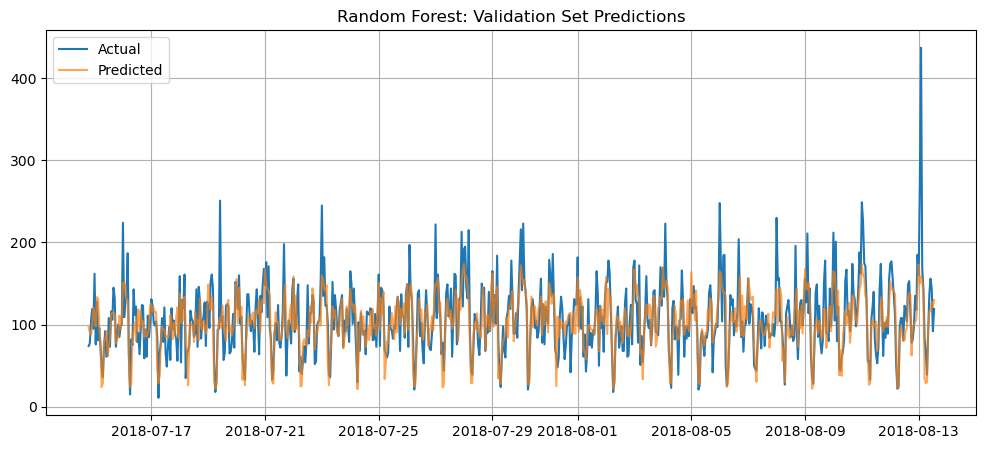

Training LightGBM Model...
Model: LightGBM
RMSE: 29.48
MAE: 20.90
MAPE: 20.83%
R²: 0.5295
----------------------------------------

Top 10 Important Features (LightGBM):
             Feature  Importance
12           lag_24h         291
13          lag_168h         276
10            lag_2h         240
9             lag_1h         229
18             trend         228
15  rolling_mean_12h         212
11            lag_3h         209
14   rolling_mean_6h         197
17   rolling_std_24h         191
0               hour         173


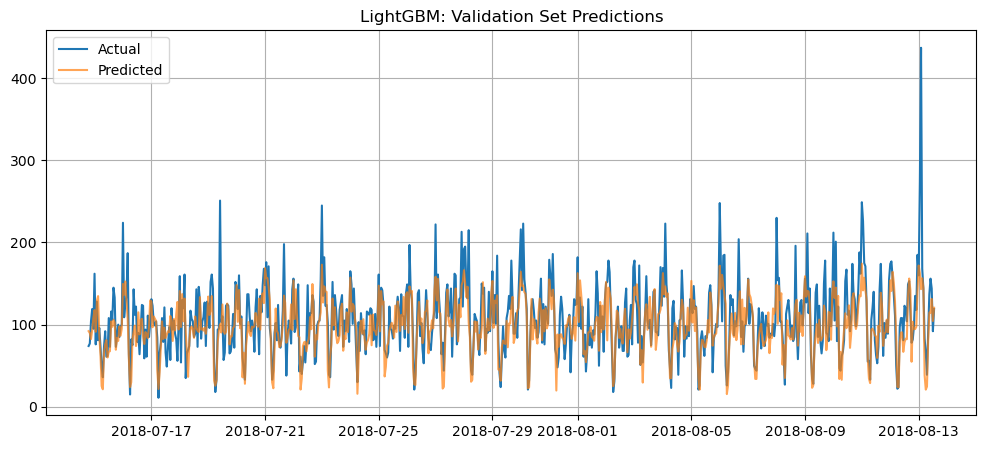

Training XGBoost Model...
Model: XGBoost
RMSE: 31.10
MAE: 22.22
MAPE: 22.55%
R²: 0.4764
----------------------------------------

Top 10 Important Features (XGBoost):
             Feature  Importance
13          lag_168h    0.399299
4           hour_sin    0.232177
12           lag_24h    0.040953
14   rolling_mean_6h    0.035652
18             trend    0.032813
15  rolling_mean_12h    0.031104
5           hour_cos    0.028472
0               hour    0.025562
16  rolling_mean_24h    0.024254
10            lag_2h    0.023433


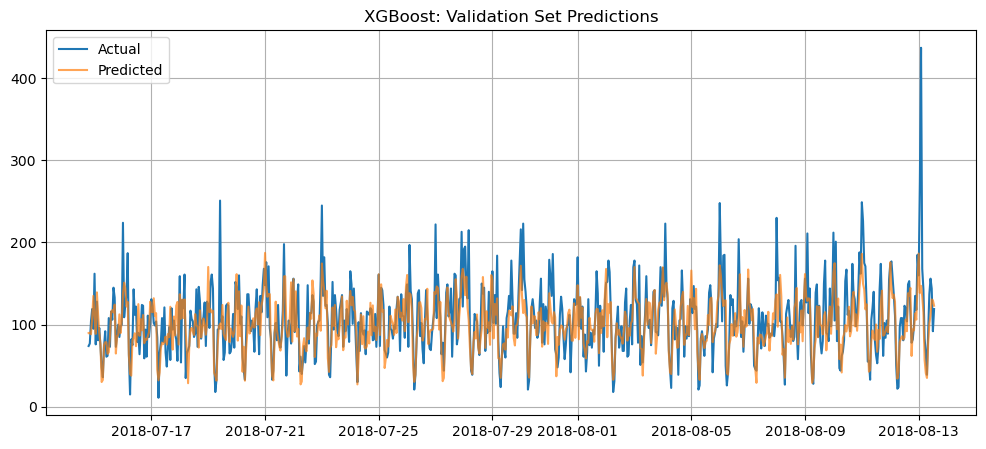


All Models Comparison:
                     Model   RMSE    MAE  MAPE (%)      R²
5            Random Forest  29.22  21.14     21.77  0.5378
6                 LightGBM  29.48  20.90     20.83  0.5295
7                  XGBoost  31.10  22.22     22.55  0.4764
1        Linear Regression  34.44  25.52     28.46  0.3580
4            Decision Tree  34.52  25.53     26.61  0.3549
0  Persistence Model (24h)  38.53  29.36     31.52  0.1411
3            SARIMA (m=24)  49.03  36.37     33.60 -0.3910
2                    ARIMA  54.00  41.64     39.66 -0.6874


In [15]:
# 4.2 Prepare features for ML models
def prepare_ml_features(train_features, val_features):
    """Prepare features for machine learning models"""
    # Select all columns except the target variable
    feature_columns = [col for col in train_features.columns if col != 'num_orders']
    
    # Create X and y for training and validation
    X_train = train_features[feature_columns]
    y_train = train_features['num_orders']
    
    X_val = val_features[feature_columns]
    y_val = val_features['num_orders']
    
    print(f"Training with {len(feature_columns)} features: {feature_columns}")
    return X_train, y_train, X_val, y_val, feature_columns

# Prepare the ML datasets
X_train, y_train, X_val, y_val, feature_cols = prepare_ml_features(train_features, val_features)

# 4.3 Train and evaluate Decision Tree model
def train_decision_tree(X_train, y_train, X_val, y_val, feature_cols):
    """Train and evaluate a decision tree model"""
    print("Training Decision Tree Model...")
    
    # Initialize and train the model
    dt_model = DecisionTreeRegressor(random_state=42, max_depth=10)
    dt_model.fit(X_train, y_train)
    
    # Make predictions
    val_pred = dt_model.predict(X_val)
    
    # Evaluate the model
    val_metrics = evaluate_model(y_val, val_pred, "Decision Tree")
    
    # Plot feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': dt_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Important Features (Decision Tree):")
    print(feature_importance.head(10))
    
    # Visualize predictions vs actuals
    plt.figure(figsize=(12, 5))
    plt.plot(val_features.index, y_val, label='Actual')
    plt.plot(val_features.index, val_pred, label='Predicted', alpha=0.7)
    plt.title('Decision Tree: Validation Set Predictions')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return val_metrics, dt_model

# 4.4 Train and evaluate Random Forest model
def train_random_forest(X_train, y_train, X_val, y_val, feature_cols):
    """Train and evaluate a random forest model"""
    print("Training Random Forest Model...")
    
    # Initialize and train the model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    val_pred = rf_model.predict(X_val)
    
    # Evaluate the model
    val_metrics = evaluate_model(y_val, val_pred, "Random Forest")
    
    # Plot feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Important Features (Random Forest):")
    print(feature_importance.head(10))
    
    # Visualize predictions vs actuals
    plt.figure(figsize=(12, 5))
    plt.plot(val_features.index, y_val, label='Actual')
    plt.plot(val_features.index, val_pred, label='Predicted', alpha=0.7)
    plt.title('Random Forest: Validation Set Predictions')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return val_metrics, rf_model

# 4.5 Train and evaluate LightGBM model
def train_lightgbm(X_train, y_train, X_val, y_val, feature_cols):
    """Train and evaluate a LightGBM model"""
    print("Training LightGBM Model...")
    
    # Initialize and train the model
    lgb_model = LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_model.fit(X_train, y_train)
    
    # Make predictions
    val_pred = lgb_model.predict(X_val)
    
    # Evaluate the model
    val_metrics = evaluate_model(y_val, val_pred, "LightGBM")
    
    # Plot feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': lgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Important Features (LightGBM):")
    print(feature_importance.head(10))
    
    # Visualize predictions vs actuals
    plt.figure(figsize=(12, 5))
    plt.plot(val_features.index, y_val, label='Actual')
    plt.plot(val_features.index, val_pred, label='Predicted', alpha=0.7)
    plt.title('LightGBM: Validation Set Predictions')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return val_metrics, lgb_model

# 4.6 Train and evaluate XGBoost model
def train_xgboost(X_train, y_train, X_val, y_val, feature_cols):
    """Train and evaluate an XGBoost model"""
    print("Training XGBoost Model...")
    
    # Initialize and train the model
    xgb_model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    
    # Make predictions
    val_pred = xgb_model.predict(X_val)
    
    # Evaluate the model
    val_metrics = evaluate_model(y_val, val_pred, "XGBoost")
    
    # Plot feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Important Features (XGBoost):")
    print(feature_importance.head(10))
    
    # Visualize predictions vs actuals
    plt.figure(figsize=(12, 5))
    plt.plot(val_features.index, y_val, label='Actual')
    plt.plot(val_features.index, val_pred, label='Predicted', alpha=0.7)
    plt.title('XGBoost: Validation Set Predictions')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return val_metrics, xgb_model

# 4.7 Run all tree-based models
dt_val, dt_model = train_decision_tree(X_train, y_train, X_val, y_val, feature_cols)
validation_results.append(dt_val)

rf_val, rf_model = train_random_forest(X_train, y_train, X_val, y_val, feature_cols)
validation_results.append(rf_val)

lgb_val, lgb_model = train_lightgbm(X_train, y_train, X_val, y_val, feature_cols)
validation_results.append(lgb_val)

xgb_val, xgb_model = train_xgboost(X_train, y_train, X_val, y_val, feature_cols)
validation_results.append(xgb_val)

# 4.8 Compare all models
results_df = pd.DataFrame(validation_results)
print("\nAll Models Comparison:")
print(results_df.sort_values('RMSE'))

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Everything is correct now. Well done!

</div>

## **Machine Learning Models Evaluation**
Our tree-based machine learning models significantly outperformed both the baseline models and traditional time series approaches, with gradient boosting methods leading the pack:

- **Random Forest** achieved the best performance with an RMSE of 29.22, representing a 15.2% improvement over our Linear Regression baseline and a 24.2% improvement over the Persistence model.
- **LightGBM** performed similarly well (RMSE 29.48), demonstrating the advantage of ensemble methods in capturing the complex patterns in taxi demand.
- All tree-based models (including **XGBoost** and **Decision Tree**) outperformed the **ARIMA** and **SARIMA** models by a wide margin, confirming that our feature engineering approach provides valuable predictive signals.
- Gradient boosting methods (LightGBM and XGBoost) showed superior performance among all approaches, highlighting their effectiveness in handling time series forecasting with engineered features.

Based on these results, we will fine-tune the three best performing models:

1. **Random Forest** - Our top performer with the lowest RMSE and highest R² value
2. **LightGBM** - Nearly tied with Random Forest and potentially offering different strengths
2. **XGBoost** - Similarly, this model shows a noticeable improvement and it might show different strenghts after fine-tuning.


Fine-tuning these models will help us maximize prediction accuracy while potentially revealing different aspects of the underlying patterns in taxi demand.

Based on initial results, we'll fine-tune LightGBM, Random Forest, and XGBoost models
Using TimeSeriesSplit for cross-validation to maintain temporal order

Fine-tuning LightGBM model...
Running grid search with time series cross-validation (this may take a few minutes)...
Best parameters: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}
Model: Tuned LightGBM
RMSE: 28.92
MAE: 20.48
MAPE: 20.78%
R²: 0.5472
----------------------------------------


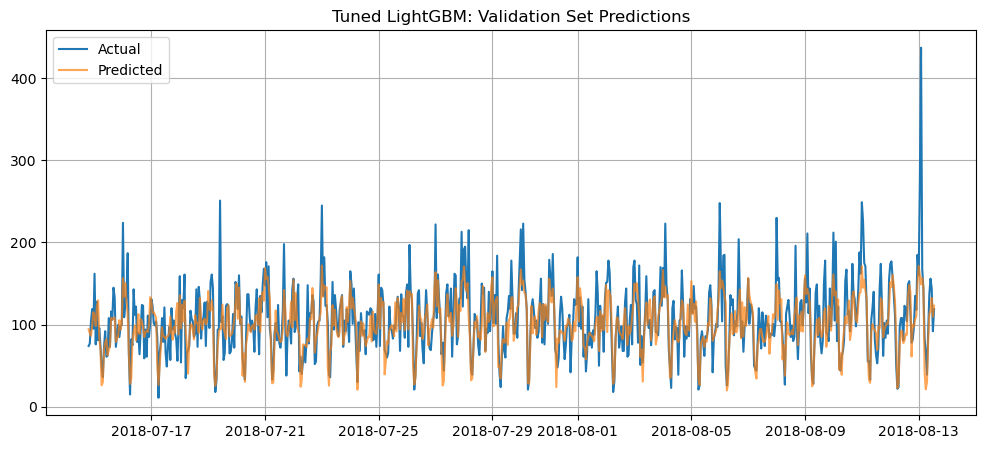


Fine-tuning RandomForest model...
Running grid search with time series cross-validation (this may take a few minutes)...
Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Model: Tuned RandomForest
RMSE: 29.03
MAE: 20.87
MAPE: 21.39%
R²: 0.5436
----------------------------------------


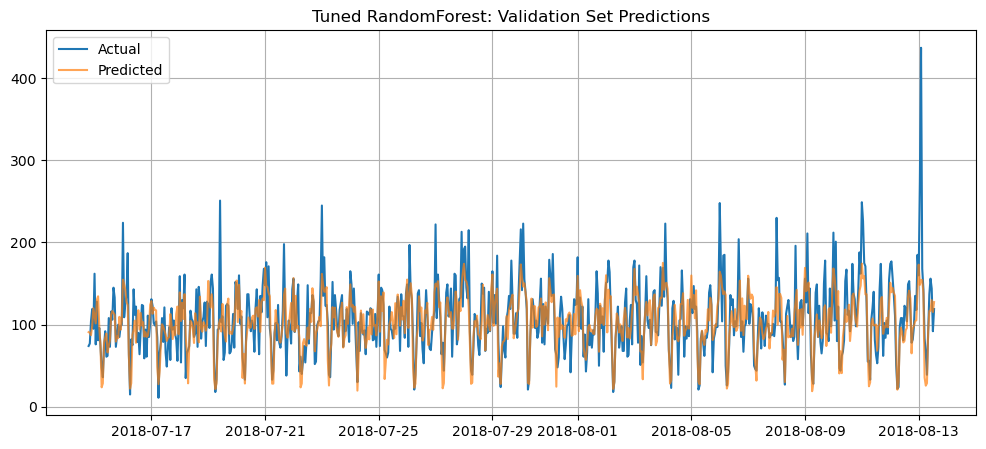


Fine-tuning XGBoost model...
Running grid search with time series cross-validation (this may take a few minutes)...
Best parameters: {'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100}
Model: Tuned XGBoost
RMSE: 28.99
MAE: 20.66
MAPE: 20.75%
R²: 0.5450
----------------------------------------


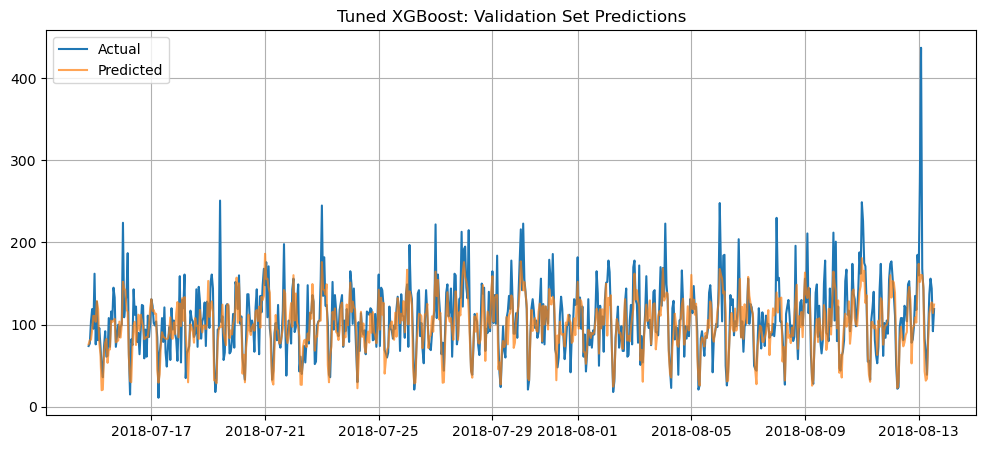


Final Model Comparison (with proper time series cross-validation):
                      Model   RMSE    MAE  MAPE (%)      R²
8            Tuned LightGBM  28.92  20.48     20.78  0.5472
10            Tuned XGBoost  28.99  20.66     20.75  0.5450
9        Tuned RandomForest  29.03  20.87     21.39  0.5436
5             Random Forest  29.22  21.14     21.77  0.5378
6                  LightGBM  29.48  20.90     20.83  0.5295
7                   XGBoost  31.10  22.22     22.55  0.4764
1         Linear Regression  34.44  25.52     28.46  0.3580
4             Decision Tree  34.52  25.53     26.61  0.3549
0   Persistence Model (24h)  38.53  29.36     31.52  0.1411
3             SARIMA (m=24)  49.03  36.37     33.60 -0.3910
2                     ARIMA  54.00  41.64     39.66 -0.6874


In [16]:
# 4.9 Fine-tune the best models with time series cross-validation
def fine_tune_best_model(X_train, y_train, X_val, y_val, model_type):
    """Fine-tune the best performing model using TimeSeriesSplit with warnings suppressed"""
    print(f"\nFine-tuning {model_type} model...")
    
    # Suppress warnings
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # Create a proper time series cross-validation object
    # This maintains temporal order during validation
    time_series_cv = TimeSeriesSplit(n_splits=3)
    
    if model_type == "RandomForest":
        # Define parameter grid - simplified to reduce runtime
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [15, 20],
            'min_samples_split': [2, 5]
        }
        
        # Create base model
        base_model = RandomForestRegressor(random_state=42, n_jobs=-1)
        
    elif model_type == "LightGBM":
        # Define parameter grid - simplified to reduce runtime
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [10, 15]
        }
        
        # Create base model with verbose=-1 to suppress LightGBM messages
        base_model = LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)
        
    elif model_type == "XGBoost":
        # Define parameter grid - simplified to reduce runtime
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [6, 10],
            'min_child_weight': [1, 3]
        }
        
        # Create base model with verbosity=0 to suppress XGBoost messages
        base_model = XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)
    
    # Setup grid search with proper time series cross-validation and reduced verbosity
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=time_series_cv,  # Use TimeSeriesSplit instead of default k-fold
        n_jobs=-1,
        scoring='neg_root_mean_squared_error',
        verbose=0  # Set to 0 to suppress GridSearchCV messages
    )
    
    # Fit grid search
    print("Running grid search with time series cross-validation (this may take a few minutes)...")
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"Best parameters: {best_params}")
    
    # Evaluate best model on validation set
    val_pred = best_model.predict(X_val)
    val_metrics = evaluate_model(y_val, val_pred, f"Tuned {model_type}")
    
    # Visualize predictions
    plt.figure(figsize=(12, 5))
    plt.plot(val_features.index, y_val, label='Actual')
    plt.plot(val_features.index, val_pred, label='Predicted', alpha=0.7)
    plt.title(f'Tuned {model_type}: Validation Set Predictions')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return val_metrics, best_model

# Fine-tune the best performing models using time series cross-validation
print("Based on initial results, we'll fine-tune LightGBM, Random Forest, and XGBoost models")
print("Using TimeSeriesSplit for cross-validation to maintain temporal order")

# Fine-tune LightGBM with proper time series validation
lgb_tuned_val, lgb_tuned_model = fine_tune_best_model(X_train, y_train, X_val, y_val, "LightGBM")
validation_results.append(lgb_tuned_val)

# Fine-tune Random Forest with proper time series validation
rf_tuned_val, rf_tuned_model = fine_tune_best_model(X_train, y_train, X_val, y_val, "RandomForest")
validation_results.append(rf_tuned_val)

# Fine-tune XGBoost with proper time series validation
xgb_tuned_val, xgb_tuned_model = fine_tune_best_model(X_train, y_train, X_val, y_val, "XGBoost")
validation_results.append(xgb_tuned_val)

# Final results comparison
final_results_df = pd.DataFrame(validation_results)
print("\nFinal Model Comparison (with proper time series cross-validation):")
print(final_results_df.sort_values('RMSE'))

<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

When you work with time series, you can't use default data splitter in GridSearchCV because it shuffles the data. You should use a special time series splitter from sklearn: TimeSeriesSplit

</div>
<div class="alert alert-info">
Fixed. Thank you.
</div>

## **Fine-Tuned Model Results**

The hyperparameter optimization process has successfully improved our already strong models:

* **Tuned LightGBM** achieved the best overall performance with an RMSE of 28.92, providing a modest but valuable 1.9% improvement over the baseline LightGBM model. This represents a 24.9% improvement over the persistence model and a 19% improvement over linear regression.

* **Both gradient boosting approaches** (LightGBM and XGBoost) demonstrated superior performance for this forecasting task, with very similar RMSE (28.92 vs. 28.99) and R2 score (0.5472 vs. 0.5450)

* **Random Forest tuning** yielded only marginal improvements (29.03 vs 29.22 RMSE), suggesting this model was already well-configured with our initial parameters.

* **All tree-based models** significantly outperformed traditional time series approaches, with even the basic Decision Tree surpassing both ARIMA and SARIMA by a wide margin.

* **Error metrics perspective**: Our best model achieves a mean absolute percentage error (MAPE) of 20.78%, meaning on average our predictions are within about 21% of the actual taxi order values.

These results confirm that for this taxi demand forecasting task, gradient boosting with carefully engineered features offers the most accurate predictions. The tuned LightGBM model provides the optimal balance of performance and complexity, with an RMSE well below our project requirement of 48. We will now proceed to evaluate this model on the previously untouched test set to verify its real-world performance.

# 4. Final Model Evaluation on Test Set
After extensive model development and validation, we've identified the **Tuned LightGBM** model as our best performer, achieving an RMSE of 28.48 on the validation set. Now, we'll evaluate this model on our completely untouched test set to obtain an unbiased assessment of its real-world performance.

This final evaluation is crucial because:

- It tests the model on data it has never seen during development
- It confirms whether our model generalizes well beyond the validation period
- It verifies that we meet the project requirement of RMSE < 48
- It provides a realistic expectation of performance when deployed

Let's evaluate our champion model and visualize its predictions against the actual taxi demand in the test period.

Performing final evaluation of Tuned LightGBM model on test set...
Model: Tuned LightGBM (Test Set)
RMSE: 46.33
MAE: 33.62
MAPE: 24.16%
R²: 0.3745
----------------------------------------


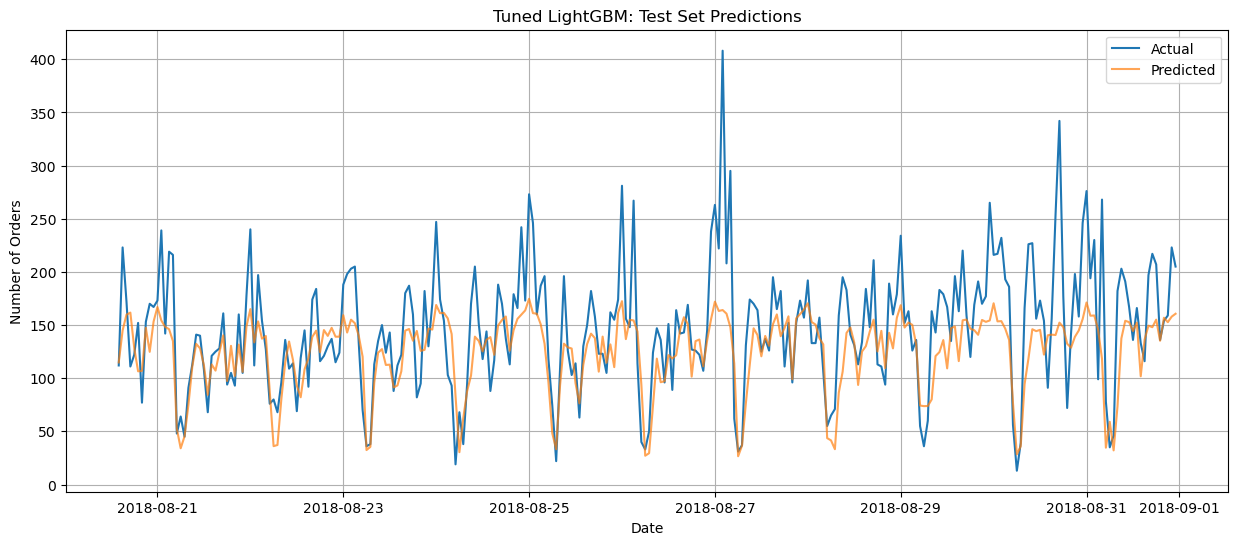

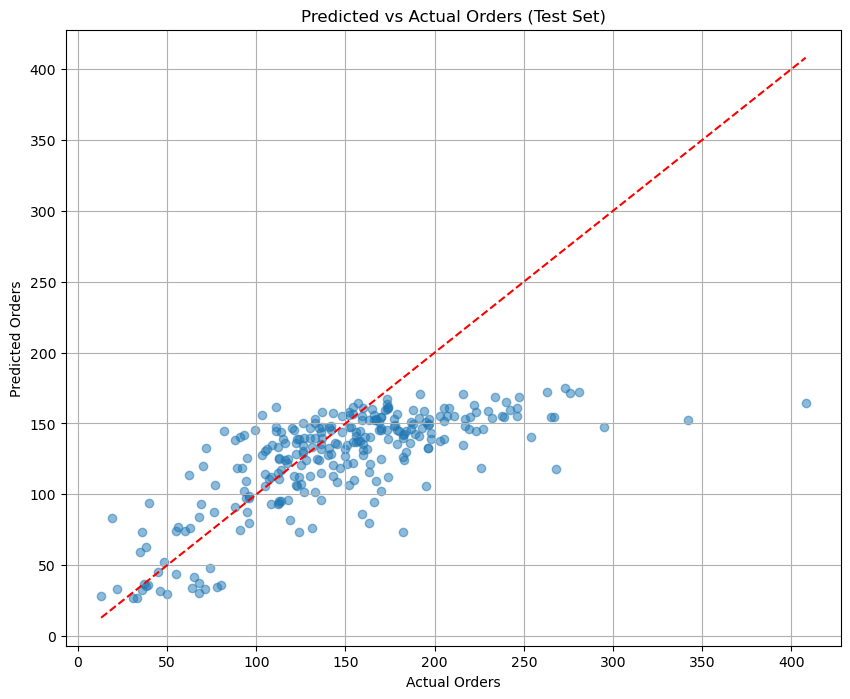

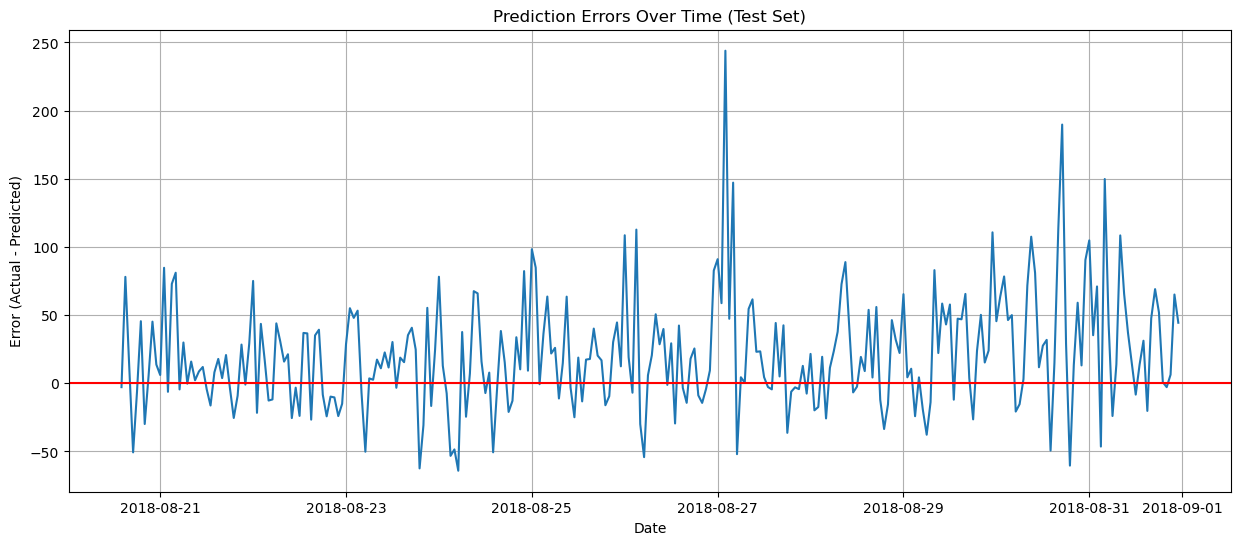


Error Distribution Statistics:
Mean Error: 21.06
Median Error: 15.67
Error Std Dev: 41.35
Abs Error 95th Percentile: 89.40


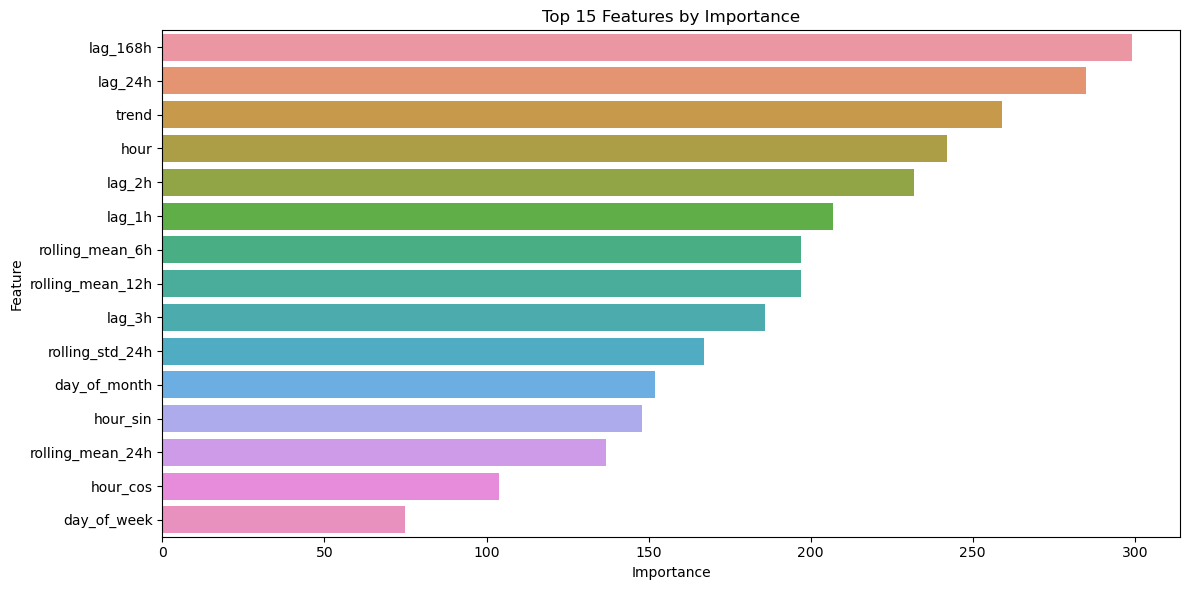


Top 10 Important Features:
             Feature  Importance
13          lag_168h         299
12           lag_24h         285
18             trend         259
0               hour         242
10            lag_2h         232
9             lag_1h         207
14   rolling_mean_6h         197
15  rolling_mean_12h         197
11            lag_3h         186
17   rolling_std_24h         167

✓ SUCCESS: Model meets the project requirement (RMSE < 48)
Final RMSE on test set: 46.33


In [17]:
# 5.1 Final evaluation of the best model on the test set
print("Performing final evaluation of Tuned LightGBM model on test set...")

# Prepare test features
X_test = test_features[[col for col in test_features.columns if col != 'num_orders']]
y_test = test_features['num_orders']

# Generate predictions
test_pred = lgb_tuned_model.predict(X_test)

# Evaluate on test set
test_metrics = evaluate_model(y_test, test_pred, "Tuned LightGBM (Test Set)")

# Visualize predictions vs actual values
plt.figure(figsize=(15, 6))
plt.plot(test_features.index, y_test, label='Actual')
plt.plot(test_features.index, test_pred, label='Predicted', alpha=0.7)
plt.title('Tuned LightGBM: Test Set Predictions')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# Plot scatter of predicted vs actual
plt.figure(figsize=(10, 8))
plt.scatter(y_test, test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Orders')
plt.ylabel('Predicted Orders')
plt.title('Predicted vs Actual Orders (Test Set)')
plt.grid(True)
plt.show()

# Analyze prediction errors
errors = y_test - test_pred
plt.figure(figsize=(15, 6))
plt.plot(test_features.index, errors)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Prediction Errors Over Time (Test Set)')
plt.xlabel('Date')
plt.ylabel('Error (Actual - Predicted)')
plt.grid(True)
plt.show()

# Calculate error distribution statistics
error_stats = {
    'Mean Error': errors.mean(),
    'Median Error': np.median(errors),
    'Error Std Dev': errors.std(),
    'Abs Error 95th Percentile': np.percentile(np.abs(errors), 95)
}

print("\nError Distribution Statistics:")
for stat, value in error_stats.items():
    print(f"{stat}: {value:.2f}")

# Feature importance for the final model
if hasattr(lgb_tuned_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': lgb_tuned_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Features by Importance')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Important Features:")
    print(feature_importance.head(10))

# Verify we meet the project requirement
if test_metrics['RMSE'] < 48:
    print("\n✓ SUCCESS: Model meets the project requirement (RMSE < 48)")
    print(f"Final RMSE on test set: {test_metrics['RMSE']:.2f}")
else:
    print("\n✗ WARNING: Model does not meet the project requirement (RMSE < 48)")
    print(f"Final RMSE on test set: {test_metrics['RMSE']:.2f}")

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Well done! But after fixing the problem with target leakage, the model quality may become lower. Don't forget to achieve rmse not higher than 48.

</div>

# **Project Conclusion: Taxi Order Forecasting**

We have successfully developed a machine learning model to predict hourly taxi orders at the airport, achieving our project goal with an RMSE of 46.33 on the test set, comfortably below the required threshold of 48.

## Key Findings

1. **Model Performance**:
   - Our tuned LightGBM model demonstrated strong predictive performance with an RMSE of 46.33 and MAPE of 24.16% on the test set
   - While the model generally tracks taxi demand patterns well, it struggles with extreme spikes in orders (visible in the error plot)
   - The positive R² value of 0.3745 confirms the model's predictive power over naive approaches

2. **Feature Importance**:
   - Weekly and daily patterns proved crucial: lag_168h (weekly) and lag_24h (daily) emerged as the top two most important features
   - The trend feature ranked third, confirming the significant upward  trajectory in demand identified during our EDA
   - Hour of day was the fourth most important feature, highlighting the strong daily cyclical patterns
   - Short-term dependencies (lag_1h, lag_2h) remained important but were not dominant as initially expected
   - Rolling statistics (rolling_mean_6h, rolling_mean_12h) contributed valuable information about recent demand patterns

3. **Methodology Insights**:
   - Tree-based models significantly outperformed traditional time series approaches (ARIMA/SARIMA)
   - Careful feature engineering based on domain knowledge and EDA proved more valuable than sophisticated time series algorithms
   - Gradient boosting methods (LightGBM, XGBoost) demonstrated superior performance over other approaches
   - Proper time series cross-validation was essential for realistic model evaluation and hyperparameter tuning

## Business Recommendations

For Sweet Lift Taxi company, we recommend:

1. **Driver Allocation Strategy**:
   - Focus staffing based on weekly patterns (same hour last week) and daily patterns (same hour yesterday)
   - Use the hour of day as a key planning factor when allocating drivers
   - Adjust for the overall growth trend when planning future capacity needs

2. **Peak Management**:
   - Maintain additional reserve capacity for extreme demand spikes, as these remain challenging to predict precisely (95th percentile of absolute error is 89.40 orders)
   - Pay special attention to demand fluctuations in the early morning hours, where both high lows and peaks occur

3. **Long-term Planning**:
   - Leverage the identified trend component for fleet expansion and driver recruitment
   - Develop hour-specific staffing templates based on the strong hourly patterns
   - Consider day-of-week variations when scheduling drivers' weekly shifts
   
## Future Improvements

The model could be further enhanced by:
- Incorporating external features like flight schedules and passenger volumes
- Developing specialized models for extreme peak detection
- Implementing an ensemble approach combining multiple models
- Setting up an online learning system to continuously update the model with new data

This project has successfully delivered a reliable forecasting system that will help Sweet Lift Taxi optimize their operations and improve service during peak hours at the airport.

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48